In [2]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# TODO: Replace <FILL IN> with appropriate code

from tensorflow.examples.tutorials.mnist import input_data as mnist_data

mnist = mnist_data.read_data_sets("./Datasets/MNIST/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./Datasets/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./Datasets/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./Datasets/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./Datasets/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as offi

In [9]:
# TODO: Replace <FILL IN> with appropriate code

# · · · · · · · · · ·    (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @ -- conv. layer 6x6x1=>6 stride 1        W1 [5, 5, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @   -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 12]
#     @ @ @ @ @ @     -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞    -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/       -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, [None, 28, 28, 1], name="input")
Y = tf.placeholder(tf.float32, shape=(None, 10), name="labels")
lr = tf.placeholder(tf.float32, shape=[])
pkeep = tf.placeholder(tf.float32, shape=[])

bias_initializer= tf.constant_initializer(value=0.1)

# three convolutional layers with their channel counts, and a fully connected layer 
# (the last layer has 10 softmax neurons)
# the output depth of first three convolutional layers, are 6, 12, 24, and the size of fully connected
# layer is 200
W1 = tf.Variable(tf.truncated_normal(shape= [5, 5, 1, 6], stddev= 0.1), name='weights1')
B1 = tf.get_variable("bias1", shape=[6], initializer=bias_initializer)

W2 = tf.Variable(tf.truncated_normal(shape= [5, 5, 6, 12], stddev= 0.1), name='weights2')
B2 = tf.get_variable("bias2", shape=[12], initializer=bias_initializer)

W3 = tf.Variable(tf.truncated_normal(shape= [4, 4, 12, 24], stddev= 0.1), name='weights3')
B3 = tf.get_variable("bias3", shape=[24], initializer=bias_initializer)

W4 = tf.Variable(tf.truncated_normal(shape= [7*7*24, 200], stddev= 0.1), name='weights4')
B4 = tf.get_variable("bias4", shape=[200], initializer=bias_initializer)

W5 = tf.Variable(tf.truncated_normal(shape= [200, 10], stddev= 0.1), name='weights5')
B5 = tf.get_variable("bias5", shape=[10], initializer=bias_initializer)

########################################
# build the model
########################################
stride = 1  # output is 28x28
Y1_hat = tf.nn.relu(tf.add(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME'), B1), name='out1')

stride = 2  # output is 14x14
Y2_hat = tf.nn.relu(tf.add(tf.nn.conv2d(Y1_hat, W2, strides=[1, stride, stride, 1], padding='SAME'), B2), name='out2')

stride = 2  # output is 7x7
Y3_hat = tf.nn.relu(tf.add(tf.nn.conv2d(Y2_hat, W3, strides=[1, stride, stride, 1], padding='SAME'), B3), name='out3')

# reshape the output from the third convolution for the fully connected layer
YY_hat = tf.reshape(Y3_hat, [-1, 7*7*24], name='put3_flattened')
Y4_hat = tf.nn.relu(tf.add(tf.matmul(YY_hat, W4), B4), name='out4')
YY4_hat = tf.nn.dropout(Y4_hat, keep_prob=pkeep, name='out4_dropped_out')
Y_hat = tf.nn.softmax(tf.add(tf.matmul(YY4_hat, W5), B5), name='output')

########################################
# define the Loss function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Y_hat, labels=Y, name='cross_entropy_loss')
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# traini the model
########################################
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 2000

max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 800.0

predictions = tf.equal(tf.argmax(Y_hat, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(predictions, tf.float32))

X_train_temp, Y_train = mnist.train.images, mnist.train.labels
X_train = np.reshape(X_train_temp, (-1, 28, 28, 1))

X_test_temp, Y_test = mnist.test.images, mnist.test.labels
X_test = np.reshape(X_test_temp, (-1, 28, 28, 1))
    
# checks if learning rate has reached its minimum value
flag = False

new_learning_rate = max_learning_rate

train_losses = []
test_accuracies = []

with tf.Session() as sess:

    sess.run(init)

    for i in range(n_epochs):

        X_batch_temp, Y_batch = mnist.train.next_batch(100)
        X_batch = np.reshape(X_batch_temp, (-1, 28, 28, 1))

        if not flag:
            new_learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * np.exp(-i / decay_speed)
            if new_learning_rate < min_learning_rate:
                flag = True
                new_learning_rate = min_learning_rate

        sess.run(train_step, feed_dict={X: X_batch, Y: Y_batch, lr: new_learning_rate, pkeep: 0.75})

        if i % 80 == 0:
            train_loss = sess.run(cross_entropy, feed_dict={X: X_train, Y: Y_train, lr: new_learning_rate, pkeep: 0.75})
            print(f'Train set loss for update step {i}: {train_loss}')
            train_losses.append(train_loss)
            test_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test, lr: new_learning_rate, pkeep: 1.0})
            print(f'Test set accuracy for update step {i}:  {round(test_accuracy*100, 2)}%')
            test_accuracies.append(test_accuracy)

    test_set_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test, lr: new_learning_rate, pkeep: 1.0})

    print('--------------------------------')
    print()
    print(f'Final test set accuracy: {round(test_set_accuracy*100, 2)}%') 

    print('####################################################################')
    print()

Train set loss for update step 0: 229.32223510742188
Test set accuracy for update step 0:  10.32%
Train set loss for update step 80: 163.96803283691406
Test set accuracy for update step 80:  83.77%
Train set loss for update step 160: 158.8289794921875
Test set accuracy for update step 160:  89.51%
Train set loss for update step 240: 154.27914428710938
Test set accuracy for update step 240:  93.46%
Train set loss for update step 320: 157.22642517089844
Test set accuracy for update step 320:  90.17%
Train set loss for update step 400: 150.9380645751953
Test set accuracy for update step 400:  95.89%
Train set loss for update step 480: 150.96690368652344
Test set accuracy for update step 480:  96.09%
Train set loss for update step 560: 150.25474548339844
Test set accuracy for update step 560:  96.77%
Train set loss for update step 640: 149.732177734375
Test set accuracy for update step 640:  96.98%
Train set loss for update step 720: 149.90243530273438
Test set accuracy for update step 720

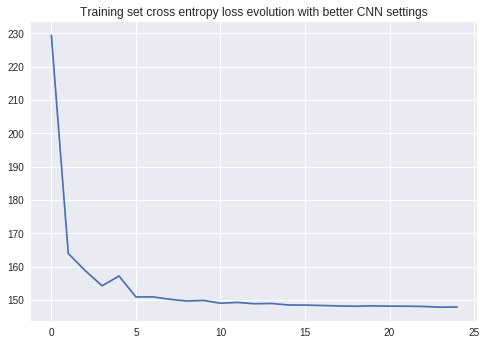

In [12]:
plt.title('Training set cross entropy loss evolution with better CNN settings')
plt.plot(train_losses)

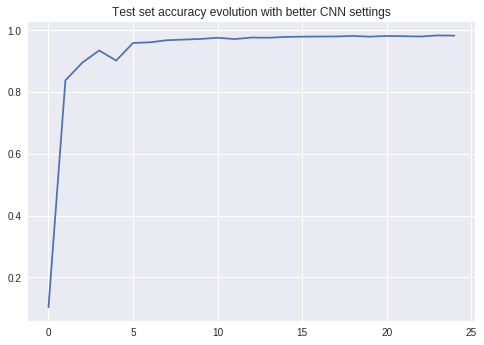

In [11]:
plt.title('Test set accuracy evolution with better CNN settings')
plt.plot(test_accuracies)